<img align="right" src="https://upload.wikimedia.org/wikipedia/commons/c/c8/Iteso_logo.jpg" width="100" height="100">

# <font color='#797983'> **Aprendizaje Profundo (Deep Learning) | Primavera 2024.**
### <font color='#1A2478'> **Instituto Tecnológico y de Estudios Superiores de Occidente**.

**<font color='#797983'>Nombre alumno:** Contreras Figueroa Javier Alejandro
   
**<font color='#797983'>Maestro:** Amezcua Ivan.
   
**<font color='#797983'>Fecha:** 29/Febrero/2024

**<font color='#797983'>Link GitHub:** https://github.com/JavierFigueroa21/DL_Auto-encoderP1
   
## <font color='#797983'> ** Proyecto l: Denoising Autoencoder **

#### 1. **Introducción:**
- Aplicación de autoencoders en imagenes, para este caso de 64 pixeles x 64 pixeles x 3 canales.

#### 2. **Objetivos:**
- El objetivo es implementar un modelo de autoencoder que sea capaz de quitar el ruido que tengan las imagenes para que la salida obtenida sea lo mas posible a las imagenes originales sin el ruido.
- Observar el comportamiento que tienen los autoencoders y  conocer el alcance que pueden tener.

In [1]:
# Trabajearemos con los datos del MedMNIST, una de las ventaas es que podemos simplemente intalarlas con un pip.
#pip install medmnist
!pip install medmnist


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=423c958c46b5cea8e4736e29911598c39ed49d1e8eda443cbe55248922b6ccdc
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


Trabajaremos con los datos que se encuentran en el MedMNIST, el cual presenta diferentes dataset de cuestiones medicas, de las cuales pueden ser con imagenes 2D o imagenes en 3D.

In [2]:
# Librerías
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPooling2D, UpSampling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy, mean_squared_error
from tensorflow.keras import backend as K
import numpy as np
from medmnist import BloodMNIST
from skimage.metrics import structural_similarity as ssim

In [3]:
import medmnist
print(medmnist.__version__)

3.0.1


- Leemos y guardamos cada uno del set de datos que usaremos, este caso no es necesario la 'y' por lo que, solamente será nuestra 'x' en train, validation y test.

In [4]:
dataset = BloodMNIST(split="train", download=True, size =64)
dataset_val = BloodMNIST(split="val", download=True, size=64)
dataset_test = BloodMNIST(split="test", download=True, size=64)

100%|██████████| 156251765/156251765 [00:07<00:00, 20146996.87it/s]


Using downloaded and verified file: /root/.medmnist/bloodmnist_64.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist_64.npz


In [5]:
dataset

Dataset BloodMNIST of size 64 (bloodmnist_64)
    Number of datapoints: 11959
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License: C

In [6]:
# Asignamos las imagenes en la varibale que correspondera para el trabajo con ellas.
x_train = dataset.imgs
x_val = dataset_val.imgs
x_test = dataset_test.imgs

In [7]:
print(f'Train data: {x_train.shape}')
print(f'Validation data: {x_val.shape}')
print(f'Test data: {x_test.shape}')

Train data: (11959, 64, 64, 3)
Validation data: (1712, 64, 64, 3)
Test data: (3421, 64, 64, 3)


- Con esto corroboramos que son la cantidad de imágenes que nos proporciona o menciona en la página es correcto.

In [8]:
print("Valor mínimo de la imagen:", np.min(x_train))
print("Valor máximo de la imagen:", np.max(x_train))

Valor mínimo de la imagen: 8
Valor máximo de la imagen: 255


In [9]:
x_train.dtype

dtype('uint8')

Tambien corroboramos si es necesario normalizar, parece que los valores se encuentran de 0 a 255, y no son de tipo al float, por cuestion de trabajo, los transformare a float32 y normalizaremos para que el rango vaya de 0 a 1.

In [10]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_val = x_val.astype('float32')/255
print("Valor mínimo de la imagen:", np.min(x_train))
print("Valor máximo de la imagen:", np.max(x_train))

Valor mínimo de la imagen: 0.03137255
Valor máximo de la imagen: 1.0


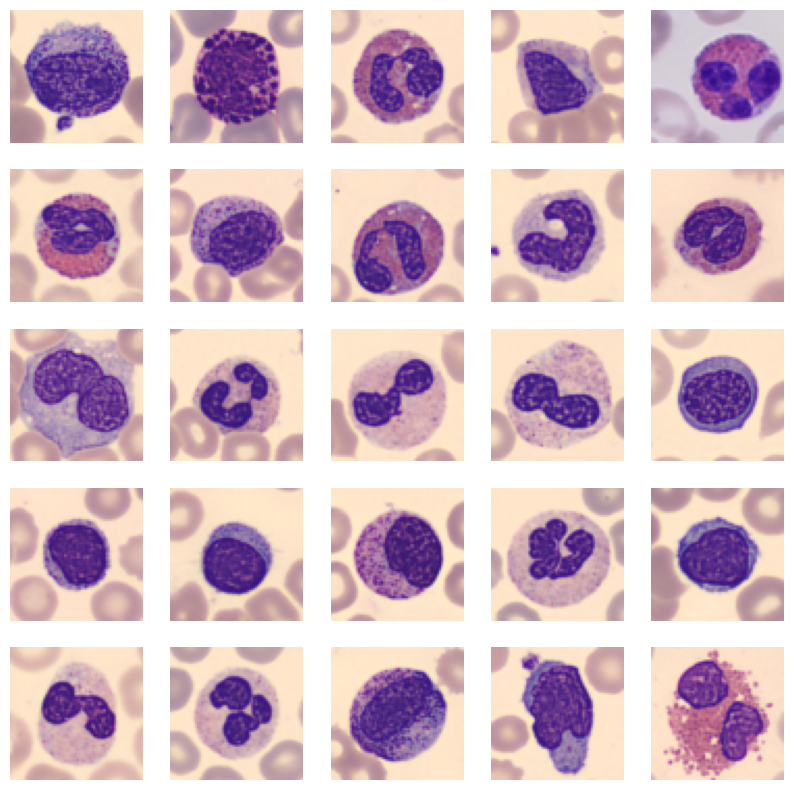

In [11]:
import matplotlib.pyplot as plt
import numpy as np
# Graficar algunas imágenes de prueba
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_test[i])
    plt.axis('off')
plt.show()

## MODEL

In [12]:
print(f'Train data: {x_train.shape}')
print(f'Validation data: {x_val.shape}')
print(f'Test data: {x_test.shape}')

Train data: (11959, 64, 64, 3)
Validation data: (1712, 64, 64, 3)
Test data: (3421, 64, 64, 3)


In [13]:
# Tomando en cuenta nuestras imágenes, nuestra entrada seguira ese orden.
input_shape=(64, 64, 3)
    # Input
input_img = Input(shape=input_shape)

    # Encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(rate=0.2)(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
encoded = Dense(128, activation='relu')(x)

    # Decoder
x = Dense(units=16 * 16 * 8, activation='relu')(encoded)
x = Reshape(target_shape=(16, 16, 8))(x)
x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
x = Dropout(rate=0.2)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)


    # Model
autoencoder = Model(input_img, decoded)

### AUTOENCODER

In [15]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 8)         0         
 g2D)                                                        

In [16]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

### Training

In [17]:
autoencoder.fit(
    x_train,
    x_train,
    batch_size = 32,
    epochs = 2,
    validation_data = (x_val, x_val)
)

Epoch 1/2
374/374 [==============================] - 12s 12ms/step - loss: 0.5313 - val_loss: 0.5152
Epoch 2/2
374/374 [==============================] - 3s 8ms/step - loss: 0.5039 - val_loss: 0.5061


In [18]:
encoded_images = autoencoder.predict(x_test)
print(f'Dimension del encodeado: {encoded_images.shape}')

107/107 [==============================] - 1s 5ms/step
Dimension del encodeado: (3421, 64, 64, 3)


In [19]:
decoder_model = Model(input_img, decoded)
predicted_images = decoder_model.predict(encoded_images)
print(predicted_images.shape)
print(f'Dimension del decodeado: {predicted_images.shape}')

107/107 [==============================] - 0s 3ms/step
(3421, 64, 64, 3)
Dimension del decodeado: (3421, 64, 64, 3)


## Visualización

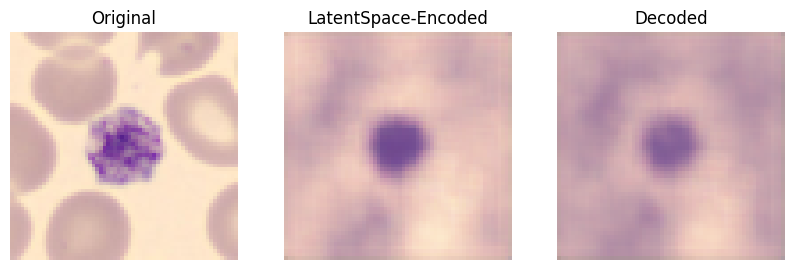

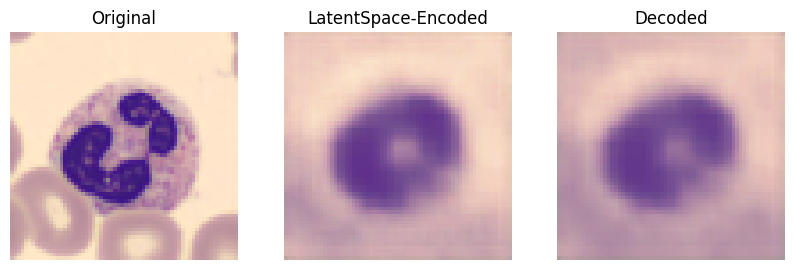

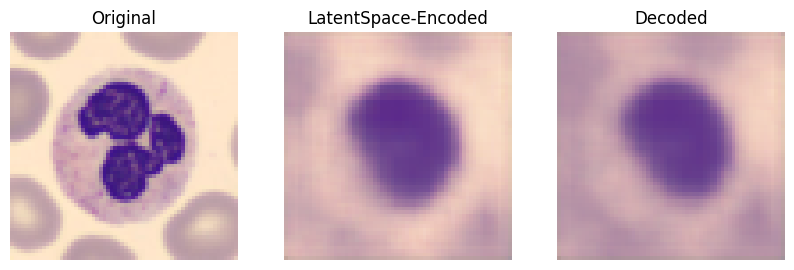

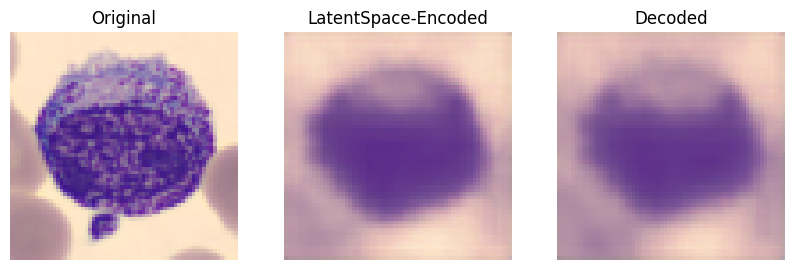

In [20]:
import matplotlib.pyplot as plt
def plot_images(original, encoded, decoded):
    n = len(original)
    plt.figure(figsize=(10, 6))
    for i in range(n):
        # Original
        plt.subplot(1, 3, 1)
        plt.imshow(original[i])
        plt.axis('off')
        plt.title('Original')

        # Encoded
        plt.subplot(1, 3, 2)
        plt.imshow(encoded[i].reshape(64, 64, 3))
        plt.axis('off')
        plt.title('LatentSpace-Encoded')

        # Decoded
        plt.subplot(1, 3, 3)
        plt.imshow(decoded[i])
        plt.axis('off')
        plt.title('Decoded')
    plt.show()


plot_images(x_test[:122], encoded_images[:122], predicted_images[:122])
plot_images(x_test[:12], encoded_images[:12], predicted_images[:12])
plot_images(x_test[:22], encoded_images[:22], predicted_images[:22])
plot_images(x_test[:1], encoded_images[:1], predicted_images[:1])

In [21]:
from skimage.metrics import structural_similarity as ssim

# Calcular SSIM entre las imágenes originales y las imágenes decodificadas
ssim_scores = []
for i in range(len(x_test)):
    ssim_score = ssim(x_test[i], predicted_images[i], multichannel=True)
    ssim_scores.append(ssim_score)

average_ssim = sum(ssim_scores) / len(ssim_scores)
print(f"\nAverage SSIM Score: {average_ssim}")

# - https://scikit-image.org/docs/stable/api/skimage.metrics.html#skimage.metrics.structural_similarity

<ipython-input-21-66e96f123034>:6: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(x_test[i], predicted_images[i], multichannel=True)



Average SSIM Score: 0.6715869597265226


In [22]:
# Labels
y_test = dataset_test.labels

107/107 [==============================] - 0s 3ms/step


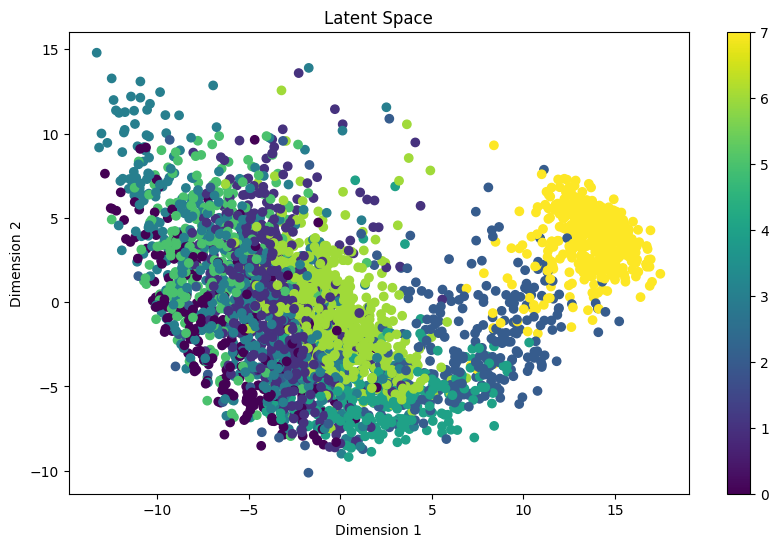

In [23]:
from sklearn.decomposition import PCA

# Obtener las representaciones latentes de un conjunto de datos de entrada
encoded_images = autoencoder.predict(x_test)

# Reducir la dimensionalidad a 2D para visualización
pca = PCA(n_components=2)
latent_space = pca.fit_transform(encoded_images.reshape(encoded_images.shape[0], -1))

# Graficar el espacio latente
plt.figure(figsize=(10, 6))
plt.scatter(latent_space[:, 0], latent_space[:, 1],c=y_test, cmap='viridis')
plt.colorbar()
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Latent Space')
plt.show()


## Introducimos el Ruido

- Los ruidos recomendados para este tipo de imagenes son el Gaussiano y Speckle.

Ruido Gaussiano:

In [24]:
# Gaussiano

def add_gaussian_noise(data, mean=0, std=0.1):
    noise = np.random.normal(mean, std, data.shape)
    noisy_data = data + noise
    return np.clip(noisy_data, 0., 1.).astype(np.float32)

x_train_Gnoisy = add_gaussian_noise(x_train, mean=0.3, std=0.5)
x_val_Gnoisy = add_gaussian_noise(x_val, mean=0.3, std=0.5)
x_test_Gnoisy = add_gaussian_noise(x_test, mean=0.3, std=0.5)



In [25]:
#print(np.max(x_train_Gnoisy)), print(np.max(x_val_Gnoisy)), print(np.max(x_test_Gnoisy))

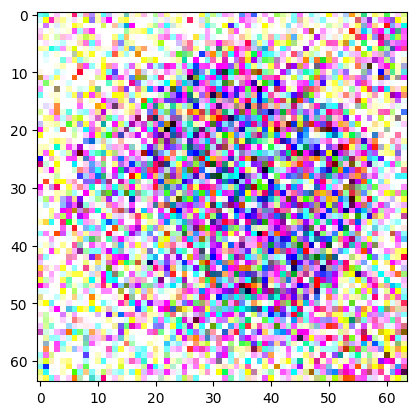

In [26]:
plt.imshow(x_train_Gnoisy[1].reshape(64,64,3))

## Model with Gaussian Noise

In [27]:
autoencoder_gaussian = Model(input_img, decoded)
autoencoder_gaussian.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder_gaussian.fit(
    x_train_Gnoisy,
    x_train,
    batch_size = 32,
    epochs = 100,
    validation_data = (x_val_Gnoisy, x_val)
)

Epoch 1/100
374/374 [==============================] - 7s 12ms/step - loss: 0.5048 - val_loss: 0.5088
Epoch 2/100
374/374 [==============================] - 3s 8ms/step - loss: 0.5023 - val_loss: 0.5084
Epoch 3/100
374/374 [==============================] - 3s 8ms/step - loss: 0.5013 - val_loss: 0.5085
Epoch 4/100
374/374 [==============================] - 3s 9ms/step - loss: 0.5005 - val_loss: 0.5061
Epoch 5/100
374/374 [==============================] - 4s 9ms/step - loss: 0.5000 - val_loss: 0.5074
Epoch 6/100
374/374 [==============================] - 3s 8ms/step - loss: 0.4995 - val_loss: 0.5052
Epoch 7/100
374/374 [==============================] - 3s 8ms/step - loss: 0.4990 - val_loss: 0.5054
Epoch 8/100
374/374 [==============================] - 3s 9ms/step - loss: 0.4987 - val_loss: 0.5057
Epoch 9/100
374/374 [==============================] - 3s 9ms/step - loss: 0.4984 - val_loss: 0.5066
Epoch 10/100
374/374 [==============================] - 3s 9ms/step - loss: 0.4982 - val_l

In [28]:
encoded_images = autoencoder_gaussian.predict(x_test_Gnoisy)
print(f'Dimension del encodeado(LatentSpace): {encoded_images.shape}')
print(" ")


#decoder_model = Autoencoder_Model()
decoder_model = Model(input_img, decoded)
predicted_images = decoder_model.predict(encoded_images)
print(predicted_images.shape)
print(f'Dimension del decodeado: {predicted_images.shape}')

107/107 [==============================] - 0s 3ms/step
Dimension del encodeado(LatentSpace): (3421, 64, 64, 3)
 
107/107 [==============================] - 0s 3ms/step
(3421, 64, 64, 3)
Dimension del decodeado: (3421, 64, 64, 3)


Text(0.5, 1.0, 'Salida')

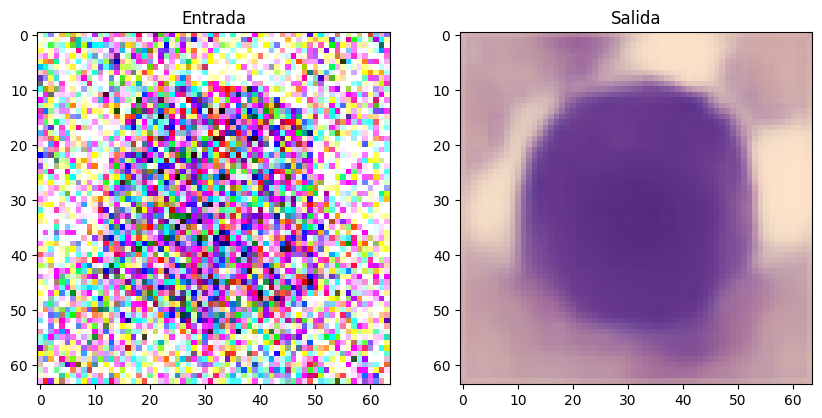

In [29]:
f = plt.figure(figsize=(10,10))
f.add_subplot(1, 2, 1)
plt.imshow(x_test_Gnoisy[1].reshape(64,64,3))
plt.title('Entrada')

f.add_subplot(1, 2, 2)
plt.imshow(predicted_images[1].reshape(64,64,3))
plt.title('Salida')

In [30]:
def plot_images(original, encoded, decoded):
    n = len(original)
    plt.figure(figsize=(10, 6))
    for i in range(n):
        # Original
        plt.subplot(1, 3, 1)
        plt.imshow(original[i])
        plt.axis('off')
        plt.title('Original Image')

        # Encoded
        plt.subplot(1, 3, 2)
        plt.imshow(encoded[i].reshape(64, 64, 3))
        plt.axis('off')
        plt.title('Input GNoise-Image')

        # Decoded
        plt.subplot(1, 3, 3)
        plt.imshow(decoded[i])
        plt.axis('off')
        plt.title('Output Image')
    plt.show()


#plot_images(x_test[:12], x_test_Gnoisy[:12], predicted_images[:12])

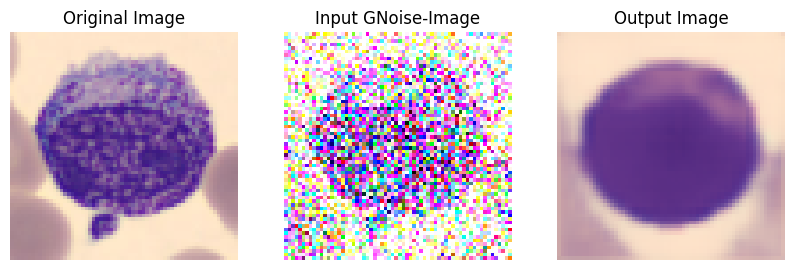

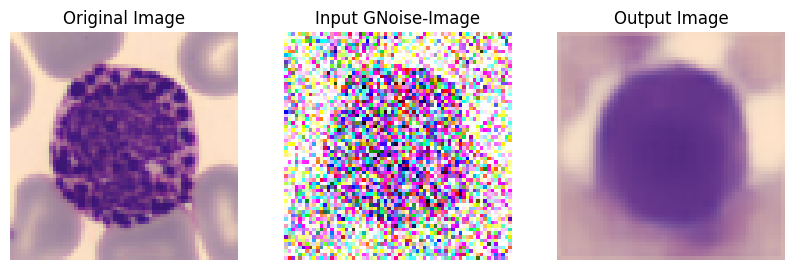

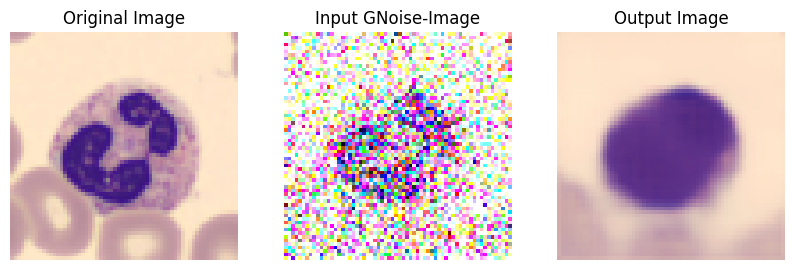

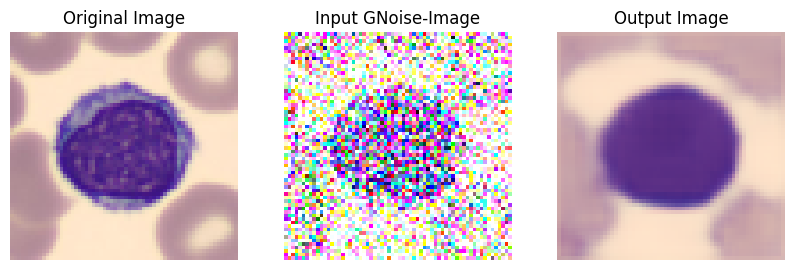

In [31]:
plot_images(x_test[:1], x_test_Gnoisy[:1], predicted_images[:1])
plot_images(x_test[:2], x_test_Gnoisy[:2], predicted_images[:2])
plot_images(x_test[:12], x_test_Gnoisy[:12], predicted_images[:12])
plot_images(x_test[:20], x_test_Gnoisy[:20], predicted_images[:20])

In [32]:
# Calcular Structure Similarity Index (SSIM) entre las imágenes originales y las imágenes decodificadas
ssim_scores = []
for i in range(len(x_test)):
    ssim_score = ssim(x_test[i], predicted_images[i], multichannel=True)
    ssim_scores.append(ssim_score)

average_ssim = sum(ssim_scores) / len(ssim_scores)
print(f"\nAverage Gaussian SSIM Score: {average_ssim}")

<ipython-input-32-50830563ca1e>:4: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(x_test[i], predicted_images[i], multichannel=True)



Average Gaussian SSIM Score: 0.7246763526400221


In [33]:
# Lo guardamos
autoencoder_gaussian.save('autoencoder_model_gaussian_noisefi.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Model with Speckle noise

- El speckle es un ruido visible dentro de una imagen proyectada. Se produce cuando una superficie rugosa (componente óptico o pantalla de proyección) es iluminada por luz coherente. Está presente en todas las fuentes de iluminación y se describe mejor como un efecto brillante o de destellos. La severidad del speckle puede variar dependiendo de la fuente de iluminación, la arquitectura óptica, la pantalla de proyección y la percepción del espectador (Maddock, Olsen y Simonsen, 24 de mayo, https://norxe.com/why-does-speckle-occur-and-how-does-this-affect-projected-images/).

In [34]:
# Speckle
def add_speckle_noise(data, mean=0, std=0.1):
    noise = np.random.normal(mean, std, data.shape)
    noisy_data = data + data * noise
    return np.clip(noisy_data, 0., 1.).astype(np.float32)



x_train_Snoisy = add_speckle_noise(x_train, mean=0.3, std=0.5)
x_val_Snoisy = add_speckle_noise(x_val, mean=0.3, std=0.5)
x_test_Snoisy = add_speckle_noise(x_test, mean=0.3, std=0.5)


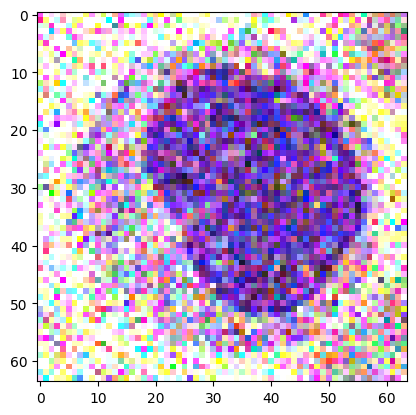

In [35]:
plt.imshow(x_train_Snoisy[1].reshape(64,64,3))

In [36]:
#autoencoder_seckle = Autoencoder_Model()
autoencoder_seckle = Model(input_img, decoded)
autoencoder_seckle.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder_seckle.fit(
    x_train_Snoisy,
    x_train,
    batch_size = 32,
    epochs = 100,
    validation_data = (x_val_Snoisy, x_val)
)

Epoch 1/100
374/374 [==============================] - 6s 11ms/step - loss: 0.4943 - val_loss: 0.4966
Epoch 2/100
374/374 [==============================] - 4s 9ms/step - loss: 0.4939 - val_loss: 0.4960
Epoch 3/100
374/374 [==============================] - 3s 9ms/step - loss: 0.4938 - val_loss: 0.4960
Epoch 4/100
374/374 [==============================] - 3s 9ms/step - loss: 0.4937 - val_loss: 0.4950
Epoch 5/100
374/374 [==============================] - 4s 10ms/step - loss: 0.4935 - val_loss: 0.4956
Epoch 6/100
374/374 [==============================] - 3s 8ms/step - loss: 0.4934 - val_loss: 0.4957
Epoch 7/100
374/374 [==============================] - 3s 9ms/step - loss: 0.4934 - val_loss: 0.4958
Epoch 8/100
374/374 [==============================] - 3s 9ms/step - loss: 0.4934 - val_loss: 0.4958
Epoch 9/100
374/374 [==============================] - 4s 10ms/step - loss: 0.4933 - val_loss: 0.4956
Epoch 10/100
374/374 [==============================] - 3s 8ms/step - loss: 0.4933 - val

In [37]:
encoded_images = autoencoder_seckle.predict(x_test_Snoisy)
print(f'Dimension del encodeado: {encoded_images.shape}')

#decoder_model = Autoencoder_Model()
decoder_model = Model(input_img,decoded)
predicted_Simages = decoder_model.predict(encoded_images)
print(predicted_images.shape)
print(f'Dimension del decodeado: {predicted_Simages.shape}')

107/107 [==============================] - 1s 3ms/step
Dimension del encodeado: (3421, 64, 64, 3)
107/107 [==============================] - 0s 3ms/step
(3421, 64, 64, 3)
Dimension del decodeado: (3421, 64, 64, 3)


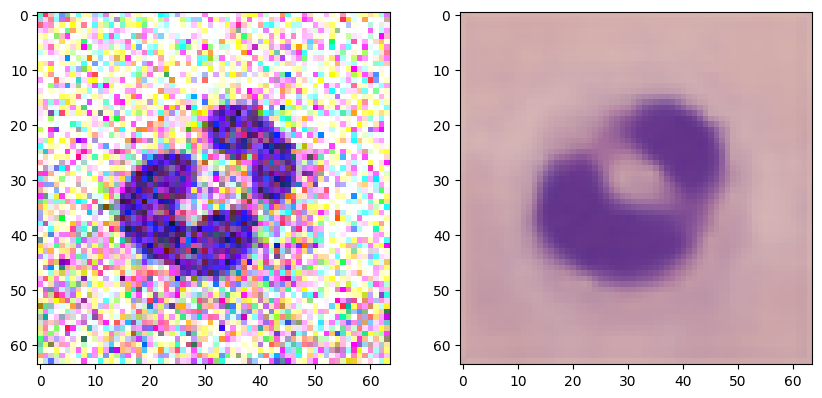

In [38]:
f = plt.figure(figsize=(10,10))
f.add_subplot(1, 2, 1)
plt.imshow(x_test_Snoisy[11].reshape(64,64,3))

f.add_subplot(1, 2, 2)
plt.imshow(predicted_Simages[11].reshape(64,64,3))

In [39]:
def plot_images(original, encoded, decoded):
    n = len(original)
    plt.figure(figsize=(10, 6))
    for i in range(n):
        # Original
        plt.subplot(1, 3, 1)
        plt.imshow(original[i])
        plt.axis('off')
        plt.title('Original Image')

        # Encoded
        plt.subplot(1, 3, 2)
        plt.imshow(encoded[i].reshape(64, 64, 3))
        plt.axis('off')
        plt.title('Input SNoise-Image')

        # Decoded
        plt.subplot(1, 3, 3)
        plt.imshow(decoded[i])
        plt.axis('off')
        plt.title('Output Image')
    plt.show()




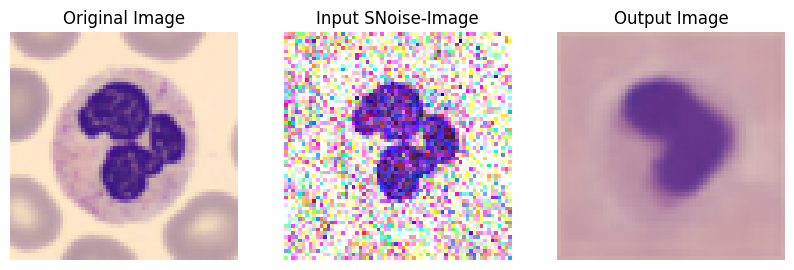

In [40]:
i = 22
plot_images(x_test[:i], x_test_Snoisy[:i], predicted_Simages[:i])

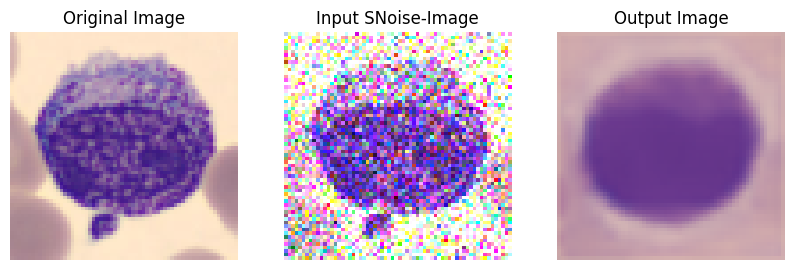

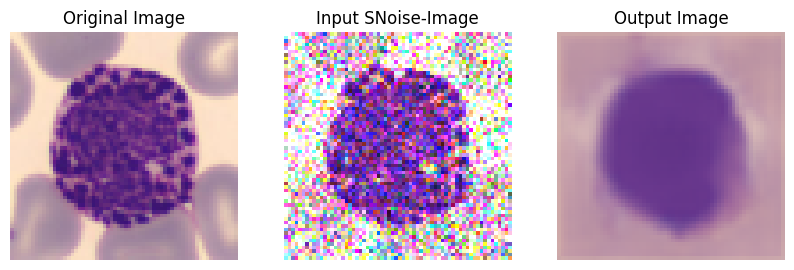

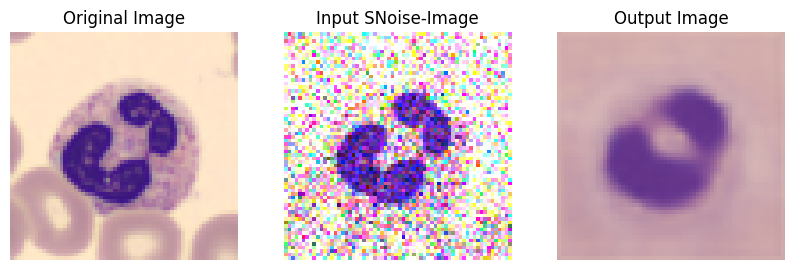

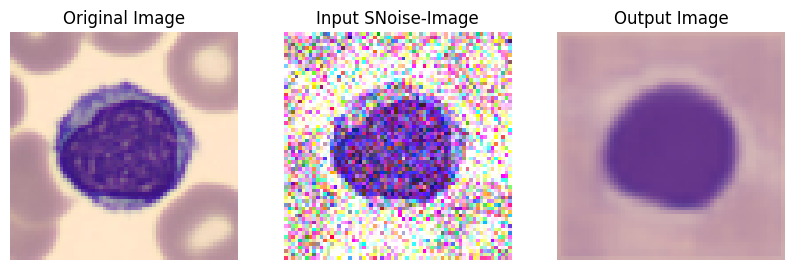

In [41]:
plot_images(x_test[:1], x_test_Snoisy[:1], predicted_Simages[:1])
plot_images(x_test[:2], x_test_Snoisy[:2], predicted_Simages[:2])
plot_images(x_test[:12], x_test_Snoisy[:12], predicted_Simages[:12])
plot_images(x_test[:20], x_test_Snoisy[:20], predicted_Simages[:20])

In [42]:
# Calcular Structure Similarity Index (SSIM) entre las imágenes originales y las imágenes decodificadas
ssim_scores = []
for i in range(len(x_test)):
    ssim_score = ssim(x_test[i], predicted_Simages[i], multichannel=True)
    ssim_scores.append(ssim_score)

averageS_ssim = sum(ssim_scores) / len(ssim_scores)
print(f"\nAverage Speackle SSIM Score: {averageS_ssim}")

<ipython-input-42-3616f26ede0a>:4: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(x_test[i], predicted_Simages[i], multichannel=True)



Average Speackle SSIM Score: 0.6990594873735689


In [43]:
print(f"Average Gaussian SSIM Score: {average_ssim}")

Average Gaussian SSIM Score: 0.7246763526400221


In [44]:
autoencoder_seckle.save('autoencoder_model_speckle_noisefi.h5')

Resultados:
Gaussian
- Average Gaussian SSIM Score: 0.6918470358872965 (30 epochs)
- Average Gaussian SSIM Score: 0.7246763526400221 (100 epochs)

Speckle
- Average Speckle SSIM Score: 0.7152669304854965 (100 epochs1)
- Average Speackle SSIM Score: 0.6990594873735689 (100 epoch2)

## Conclusiones:
- En términos generales, el modelo logra eliminar ambos tipos de ruido de manera ciertamente efectiva, siendo el ruido de Gaussiano ligeramente más efectivo que el ruido Speckle, aunque la diferencia es mínima. Ambos ruidos alcanzan resultados óptimos en aproximadamente 20 a 30 épocas de entrenamiento, más allá de las cuales apenas se observa mejora. Por lo tanto, con 20 épocas sería suficiente para obtener resultados aceptables sin necesidad de utilizar más recursos computacionales.

- En condiciones similares, se notó que el ruido de Gaussiano tiene un desempeño ligeramente mejor que el ruido Speckle, aunque la diferencia es poco relevante.

- Podríamos considerar una exploración más detallada de la arquitectura del modelo, incluyendo diversas funciones de activación, funciones de pérdida, ajustes en hiperparámetros y otras combinaciones potenciales.

- Aunque el modelo parece tener un buen rendimiento, visualmente aún no se aprecian los detalles de manera clara. Sería necesario investigar si un autoencoder variacional podría mejorar el rendimiento o si, en este caso, el problema no es adecuado para abordarlo con autoencoders o incluso que sea una investigación exhaustiva.

## Referencias

- Yang, J., Shi, R., Ni, B. (2021). MedMNIST Classification Decathlon: A Lightweight AutoML Benchmark for Medical Image Analysis. En *IEEE 18th International Symposium on Biomedical Imaging (ISBI)* (pp. 191-195).

- Jiancheng Yang, Rui Shi, Donglai Wei, Zequan Liu, Lin Zhao, Bilian Ke, Hanspeter Pfister, Bingbing Ni. Yang, Jiancheng, et al. "MedMNIST v2-A large-scale lightweight benchmark for 2D and 3D biomedical image classification." Scientific Data, 2023.

- Jiancheng Yang, Rui Shi, Bingbing Ni. "MedMNIST Classification Decathlon: A Lightweight AutoML Benchmark for Medical Image Analysis". IEEE 18th International Symposium on Biomedical Imaging (ISBI), 2021.

- Yang, J., Shi, R., Wei, D., Liu, Z., Zhao, L., Ke, B., Pfister, H., Ni, B. (2023). MedMNIST v2-A large-scale lightweight benchmark for 2D and 3D biomedical image classification. *Scientific Data, 10*(1), 41.

- Acevedo, A., Merino, A., Alférez, S., Molina, Á., Boldú, L., Rodellar, J. (2020). A dataset of microscopic peripheral blood cell images for development of automatic recognition systems. *Data in Brief, 30*, 105474.

- MedMNIST. (2024). MedMNIST. GitHub. https://github.com/MedMNIST/MedMNIST

- Yadav, S. (17 de junio de 2020). Speckle vs Gaussian Noise? Medium. Recuperado de https://medium.com/@sunil7545/speckle-vs-gaussian-noise-7f4f47230d82

- Maddock, C., Olsen, K. E., & Simonsen, T. (24 de mayo). Speckle characteristics of true solid-state illumination technology projectors. Recuperado de https://norxe.com/why-does-speckle-occur-and-how-does-this-affect-projected-images/

- Martínez, J. (20 de abril de 2021). Reducción de ruido en imágenes con scikit-image y scipy. Recuperado de https://www.datasmarts.net/reduccion-de-ruido-en-imagenes-con-scikit-image-y-scipy/

- scikit-image. (2024). skimage.metrics.structural_similarity. Recuperado de https://scikit-image.org/docs/stable/api/skimage.metrics.html#skimage.metrics.structural_similarity.

- scikit-image. (2022). skimage/metrics/_structural_similarity.py (versión 0.22.0). GitHub. https://github.com/scikit-image/scikit-image/blob/v0.22.0/skimage/metrics/_structural_similarity.py#L15-L275